In [5]:
# get_ipython().magic('matplotlib notebook')
get_ipython().magic('matplotlib inline')
get_ipython().magic('load_ext autoreload')
get_ipython().magic('autoreload 2')
#___________________________________________________________________________________________________________________
import os
import tripyview as tpv
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
# Parameters
# mesh_path  ='/work/ollie/projects/clidyn/FESOM2/meshes/core2/'
mesh_path ='/work/ollie/pscholz/mesh_fesom2.0/core2_srt_dep@node/'
save_path  = None #'~/figures/test_papermill/'
save_fname = None

#_____________________________________________________________________________________
which_cycl = 5
which_mode = 'hslice_clim'

#_____________________________________________________________________________________
input_paths= list()
# input_paths.append('/home/ollie/pscholz/results/trr181_tke+idemix_jayne_bin_ck0.1/')
# input_paths.append('/home/ollie/pscholz/results/trr181_tke+idemix_nycander_bin_ck0.1/')
# input_paths.append('/home/ollie/pscholz/results/trr181_tke+idemix_stormtide_bin_ck0.1/')
input_paths.append('/home/ollie/pscholz/results/trr181_tke_ctrl_ck0.1_v2/')

input_names= list()
# input_names.append('TKE+IDEMIX, jayne')
# input_names.append('TKE+IDEMIX, nycander')
# input_names.append('TKE+IDEMIX, stormtide')
input_names.append('TKE')

vname      = 'temp'
year       = [1979,2019]
mon, day, record, box, depth = None, None, None, None, 1000

#_____________________________________________________________________________________
# do anomaly plots in case ref_path is not None
ref_path  = None #'/home/ollie/pscholz/results/trr181_tke_ctrl_ck0.1/' # None
ref_name  = None #'TKE, ck=0.1' # None
ref_year  = None # [2009,2019]
ref_mon, ref_day, ref_record = None, None, None

#_____________________________________________________________________________________
which_clim = 'phc3'
clim_path  = '/work/ollie/pscholz/INIT_HYDRO/phc3.0/phc3.0_annual.nc'

#_____________________________________________________________________________________
cstr       = 'blue2red'
cnum       = 20
cref       = 0
crange, cmin, cmax, cfac, climit = None, None, None, None, None
chist, ctresh = True, 0.995

#_____________________________________________________________________________________
ncolumn    = 3 
do_rescale = None
which_dpi  = 300
proj       = 'pc'
do_plot    = 'tcf'

In [7]:
#___LOAD FESOM2 MESH___________________________________________________________________________________
mesh=tpv.load_mesh_fesom2(mesh_path, do_rot='None', focus=0, do_info=True, do_pickle=True)

#______________________________________________________________________________________________________
if which_cycl is not None: 
    for ii,ipath in enumerate(input_paths):
        input_paths[ii] = os.path.join(ipath,'{:d}/'.format(which_cycl))
        print(ii, ipath, input_paths[ii])

    if ref_path is not None:
        ref_path = os.path.join(ref_path,'{:d}/'.format(which_cycl))
        print('R', ref_path)        

#______________________________________________________________________________________________________        
cinfo=dict({'cstr':cstr, 'cnum':cnum})     
if crange   is not None: cinfo['crange']=crange
if cmin     is not None: cinfo['cmin'  ]=cmin
if cmax     is not None: cinfo['cmax'  ]=cmax
if cref     is not None: cinfo['cref'  ]=cref
if cfac     is not None: cinfo['cfac'  ]=cfac
if climit   is not None: cinfo['climit']=climit
if chist    is not None: cinfo['chist' ]=chist
if ctresh   is not None: cinfo['ctresh']=ctresh
if ref_path is not None: cinfo['cref'  ]=0.0    
    
#______________________________________________________________________________________________________
# in case of diff plots
if ref_path is not None:
    if ref_year   is None: ref_year   = year
    if ref_mon    is None: ref_mon    = mon
    if ref_record is None: ref_record = record    
        
#______________________________________________________________________________________________________    
# concatenate list = list1+list2
if ref_path is not None: 
    if isinstance(ref_path, list): 
        input_paths, input_names = ref_path + input_paths, ref_name + input_names
    else:    
        input_paths, input_names = list([ref_path]) + input_paths, list([ref_name]) + input_names        

 > found *.pckl file: /work/ollie/pscholz/mesh_fesom2.0/core2_srt_dep@node
 > load  *.pckl file: tripyview_fesom2_core2_srt_dep@node.pckl
 > comp. e_resol from mean
___FESOM2 MESH INFO________________________
 > path            = /work/ollie/pscholz/mesh_fesom2.0/core2_srt_dep@node
 > id              = core2_srt_dep@node
 > do rot          = None
 > [al,be,ga]      = 50, 15, -90
 > do augmpbnd     = True
 > do cavity       = False
 > do lsmask       = True
 > do earea,eresol = True, True
 > do narea,nresol = True, True
___________________________________________
 > #node           = 126858
 > #elem           = 244659
 > #lvls           = 48
___________________________________________
0 /home/ollie/pscholz/results/trr181_tke_ctrl_ck0.1_v2/ /home/ollie/pscholz/results/trr181_tke_ctrl_ck0.1_v2/5/


In [8]:
#___LOAD Climatology DATA______________________________________________________________________________
clim_vname = vname
if (vname in ['temp', 'salt', 'pdens'] or 'sigma' in vname) and (depth is not 'bottom'): 
    if   vname=='temp' and  which_clim.lower()=='woa18': clim_vname = 't00an1'
    elif vname=='salt' and  which_clim.lower()=='woa18': clim_vname = 's00an1'
    clim = tpv.load_climatology(mesh, clim_path, clim_vname, depth=depth)
else: raise ValueError('climatology not supported for choosen vname')    

#___LOAD FESOM2 DATA___________________________________________________________________________________
data_list = list()
for datapath,descript in zip(input_paths, input_names): 
    print(datapath)
    data = tpv.load_data_fesom2(mesh, datapath, vname=vname, year=year, mon=mon, day=day, record=record, 
                                depth=depth, descript=descript, do_info=False)
    data_list.append(tpv.do_anomaly(data, clim))
    del data   

/home/ollie/pscholz/results/trr181_tke_ctrl_ck0.1_v2/5/


--> histo: cmin, cmax =  -3.007436515815243 2.1160148919976907
{'cstr': 'blue2red', 'cnum': 20, 'cref': 0, 'chist': True, 'ctresh': 0.995, 'cmin': -3.0074, 'cmax': 2.116, 'cmap': <matplotlib.colors.ListedColormap object at 0x7f0308324310>, 'clevel': array([-3.25, -3.  , -2.75, -2.5 , -2.25, -2.  , -1.75, -1.5 , -1.25,
       -1.  , -0.75, -0.5 , -0.25,  0.  ,  0.25,  0.5 ,  0.75,  1.  ,
        1.25,  1.5 ,  1.75,  2.  ,  2.25])}


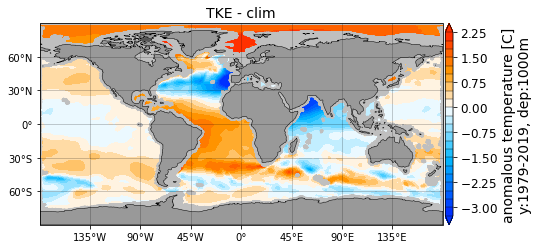

In [9]:
#___PLOT FESOM2 DATA___________________________________________________________________________________
spath  = save_path
sname  = vname
slabel = data_list[0][sname].attrs['str_lsave']
if spath is not None: spath = os.path.join(spath,'{}_{}_{}.png'.format(which_mode, sname, slabel)) 
ncolumn= np.min([ncolumn,len(data_list)])    
nrow   = np.ceil(len(data_list)/ncolumn).astype('int')
if save_fname is not None: spath = save_fname
pos_gap = [0.005, 0.04]
if   proj in ['nps, sps']:pos_gap = [0.005, 0.035] 
elif proj in ['rob']     :pos_gap = [0.005, -0.02] 
fig, ax, cbar = tpv.plot_hslice(mesh, data_list, cinfo=cinfo, box=box, n_rc=[nrow, ncolumn], 
                            figsize=[ncolumn*7, nrow*3.5], proj = proj,  do_plot = do_plot,
                            do_lsmask='fesom', do_rescale=do_rescale, title='descript', 
                            pos_gap=pos_gap, pos_extend=[0.05, 0.05, 0.85, 0.90], 
                            do_save=spath, save_dpi=which_dpi)